In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from scipy.optimize import minimize, dual_annealing
import json
from simanneal import Annealer
from warnings import filterwarnings
from skopt import gp_minimize

# Homework 6

## Question 1 <font color="magenta">(1 point, manual)</font>

Use the `simanneal` package to find a tour of the 48 state capitals that is less than 18,000 km in length and has no self-intersection (crossovers).  The global minimum for total distance is 17,357 km, but you don't need to find that.  Use the plotting code from Lesson 5 to show a picture of the tour that includes the distance. 
In the space below, include your picture of the tour that includes the distance.  Do not include code here, instead include it in Question 2.

## Question 2 <font color="magenta">(5 points, manual)</font>

Include your code for using `simanneal` and plotting the tour in the space below.  Also make sure your code is in CoCalc and that it has been executed with output showing.

 Temperature        Energy    Accept   Improve     Elapsed   Remaining


 Temperature        Energy    Accept   Improve     Elapsed   Remaining


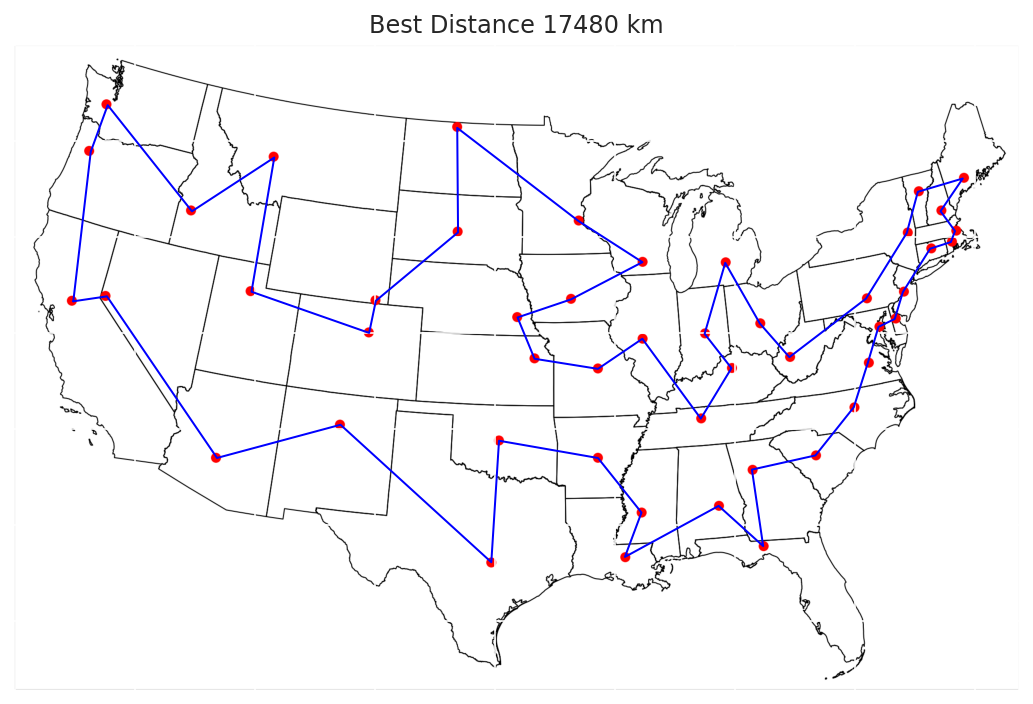

In [2]:
import numpy as np
import json
from simanneal import Annealer
# read data
with open("data/Caps48.json", "r") as tsp_data:
    data = json.load(tsp_data)

def tour_distance(tour, dist_mat):
    distance = dist_mat[tour[-1]][tour[0]]
    for gene1, gene2 in zip(tour[0:-1], tour[1:]):
        distance += dist_mat[gene1][gene2]
    return distance/1000 # convert to kilometers


def sub_tour_reversal(tour):
    # reverse a random tour segment
    n = len(tour)
    i, j = np.sort(np.random.choice(n, 2, replace=False))
    return (np.concatenate((tour[0:i], tour[j:-n + i - 1:-1], tour[j + 1:n])))


# build the class
class TravellingSalesmanProblem(Annealer):
    # pass extra data to the constructor
    def __init__(self, state, distance_matrix):
        self.distance_matrix = distance_matrix
        super(TravellingSalesmanProblem, self).__init__(state)  # important!

    def move(self):
        self.state = sub_tour_reversal(self.state)

    def energy(self):
        return tour_distance(self.state, self.distance_matrix)


dist_matrix = data['DistanceMatrix']
init_tour = np.random.permutation(np.arange(len(dist_matrix))).astype(int).tolist()

tsp = TravellingSalesmanProblem(init_tour, dist_matrix)
tsp.set_schedule(tsp.auto(minutes=.2)) #set approximate time to find results

best_tour, best_dist = tsp.anneal()

xy = np.array(data["Coordinates"])

def plot_tour(best_tour, xy_meters, best_dist, height, width):

    meters_to_pxl = 0.0004374627441064968
    intercept_x = 2.464
    intercept_y = 1342.546
    xy_pixels = np.zeros(xy_meters.shape)
    xy_pixels[:,0] = meters_to_pxl * xy_meters[:,0] + intercept_x
    xy_pixels[:,1] = -meters_to_pxl * xy_meters[:,1] + intercept_y

    fig, ax = plt.subplots(1, 1, figsize=(height, width))
    im = plt.imread('images/caps48.png')
    implot = ax.imshow(im)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)

    loop_tour = np.append(best_tour, best_tour[0])
    ax.plot(xy_pixels[loop_tour, 0],
            xy_pixels[loop_tour, 1],
            c='b',
            linewidth=1,
            linestyle='-')
    plt.title(f"Best Distance {best_dist:.0f} km")

plot_tour(best_tour, xy, best_dist, 9, 6)

## Question 3 <font color="magenta">(1 point, manual)</font>

Use simulated annealing in the `simanneal` package to solve the knapsack problem introduced in Lesson 5 and Homework 5.  Your "move" function/method should use a "hard constraint" and reject any potential knapsack solutions with weight greater than 50:
* copy `self.state` with `new_state = self.state.copy()`
* make a move on `new_state` (toggle a random item like in HW 5)
* if the total weight of `new_state` is $\leq 50$ then `set self.state = new_state`
* else don't change `self.state`.

Your fitness function/method should return the negative total value of the items in the knapsack since `simanneal` is for minimizing functions, but here we want the maximum.  Use this exact code to set up the knapsack.  Do not change anything.

**Note:  the move method doesn't return anything, it should simply modify self.state.**

```
# generate random weights and values for a knapsack problem
# DO NOT CHANGE ANYTHING in this block of code
import numpy as np
num_items = 20
np.random.seed(seed=123) 
values = np.random.randint(low=5, high=50, size=num_items)
weights = np.random.randint(low=1, high=10, size=num_items)
max_weight = 50
np.random.seed() # use system clock to reset the seed so future random numbers will appear random
```

Simanneal should be able to find the global maximum value.
Execute your code a few times and report the maximum (positive) total value for the items in the knapsack.  **Note:  simanneal is for *minimizing* functions.**

**435**

## Question 4 <font color="magenta">(1 point, auto)</font>

How many items are included in your optimized knapsack?

**13**


## Question 5 <font color="magenta">(4 points, manual)</font>

Include the complete code for your simanneal solution to the "hard constraint" knapsack problem in the cell below.  Your complete and executed code must be in CoCalc also.

In [3]:
# generate random weights and values for a knapsack problem
# DO NOT CHANGE ANYTHING in this block of code
num_items = 20
np.random.seed(seed=123) 
values = np.random.randint(low=5, high=50, size=num_items)
weights = np.random.randint(low=1, high=10, size=num_items)
max_weight = 50
np.random.seed() # use system clock to reset the seed so future random numbers will appear random

# the objective function
def neg_sum(groups, values, num_groups):
	return -sum(values[groups.astype(bool)])

# the move function
def change_group(groups, num_groups, debug=False):
	new_groups = groups.copy()    
	switch = np.random.randint(0, groups.shape[0])
	new_group = np.random.randint(0,num_groups)
	while groups[switch] == new_group:
		new_group = np.random.randint(0,num_groups)
	new_groups[switch] = new_group
	if debug:
		print(f'The item at {switch} should change to {new_group}')
		print(f'The initial groups are: {groups} and the changed groups are {new_groups}')

	return new_groups

def get_weight(groups, weights):
	return sum(weights[groups.astype(bool)])

class ValueBalancing(Annealer):
    
	def __init__(self, state, values, weights, num_groups, max_weight=50):
		self.values = values
		self.weights = weights
		self.num_groups = num_groups
		self.max_weight = max_weight
		super(ValueBalancing, self).__init__(state)

	def move(self):
		new_state = self.state.copy()
		new_state = change_group(new_state, self.num_groups)
		while get_weight(new_state, weights) > self.max_weight:
			new_state = change_group(new_state, self.num_groups)
		self.state = new_state

	def energy(self):
		return neg_sum(self.state, self.values, self.num_groups)

num_groups = 2
group_init = np.random.randint(num_groups,size=num_items)

obj = ValueBalancing(group_init, values, weights, num_groups)
obj.set_schedule(obj.auto(minutes=.2))
groups, fitness = obj.anneal()

print(f'The total weight of knapsack is {sum(weights[groups.astype(bool)])}, its value is {-fitness}, and it has {sum(groups)} members')

 Temperature        Energy    Accept   Improve     Elapsed   Remaining


 Temperature        Energy    Accept   Improve     Elapsed   Remaining


The total weight of knapsack is 50, its value is 435, and it has 13 members


## Question 6 <font color="magenta">(1 point, auto)</font>

Use `simanneal` to solve the knapsack problem again.  This time use a "soft constraint" approach.  This means all knapsacks can be considered, even those that are over 50 in total weight, so the move function should not reject any potential solutions.  Soft constraints are implemented by including a penalty in the objective function when the proposed solution doesn't satisfy the constraint.  To do this, you'll modify the function called by the energy() method:
```
def knapsack_value_penalty(x, values, weights, max_tot_weight):
    # x is a vector of booleans of which items to include
    tot_value = sum(values[x])
    penalty = sum(values)*min( max_tot_weight - sum(weights[x]), 0) 
    return tot_value+penalty
```
The penalty here is negative when the total weight is too large so that the optimizer knows it hasn't found a good maximizing solution and will continue to look elsewhere.

You should be able to find the global maximum with this approach.  What is the maximum total value of the knapsack?  If you've done everything correctly the answer should be the same as in Question 3.

## Question 7 <font color="magenta">(5 points, manual)</font>

Include your complete code for the soft constraint approach to the knapsack problem in the space below.  Also make sure the code is in CoCalc and that it has been executed there.


In [4]:
def knapsack_value_penalty(x, values, weights, max_tot_weight):
    # x is a vector of booleans of which items to include
    tot_value = sum(values[x])
    penalty = sum(values)*min( max_tot_weight - sum(weights[x]), 0) 
    return -tot_value-penalty

# the move function
def change_group(groups, num_groups, debug=False):
	new_groups = groups.copy()    
	switch = np.random.randint(0, groups.shape[0])
	new_group = np.random.randint(0,num_groups)
	while groups[switch] == new_group:
		new_group = np.random.randint(0,num_groups)
	new_groups[switch] = new_group
	if debug:
		print(f'The item at {switch} should change to {new_group}')
		print(f'The initial groups are: {groups} and the changed groups are {new_groups}')

	return new_groups

def get_weight(groups, weights):
	return sum(weights[groups.astype(bool)])

class ValueBalancing(Annealer):
    
	def __init__(self, state, values, weights, num_groups, max_weight=50):
		self.values = values
		self.weights = weights
		self.num_groups = num_groups
		self.max_weight = max_weight
		super(ValueBalancing, self).__init__(state)

	def move(self):
		self.state = change_group(self.state, self.num_groups)

	def energy(self):
		return knapsack_value_penalty(self.state.astype(bool), self.values, self.weights, self.max_weight)

num_groups = 2
group_init = np.random.randint(num_groups,size=num_items)

obj = ValueBalancing(group_init, values, weights, num_groups)
obj.set_schedule(obj.auto(minutes=.2))
groups, fitness = obj.anneal()

print(f'The total weight of knapsack is {sum(weights[groups.astype(bool)])}, its value is {-fitness}, and it has {sum(groups)} members')

 Temperature        Energy    Accept   Improve     Elapsed   Remaining


 Temperature        Energy    Accept   Improve     Elapsed   Remaining


The total weight of knapsack is 50, its value is 435, and it has 13 members


## Questions 8 - 20 Text

In the following you're going to minimize the ten-dimension Rastrigin
 function several different ways and compare the results.  The Rastrigin function was introduced in Lesson 5 and Homework 5.  Make sure using decision variables $x_1, x_2, \ldots, x_{10}$ that are in one array / list / numpy array with 10 elements.  The bounds are $-5.12 \leq x_i \leq 5.12$ for each $i$.  The global minimum value is 0 and occurs when $x_1 = x_2 = \ldots = x_{10} = 0$.  At the end you'll compare the efficiency of the optimization algorithms. 
 
Note, the Rastrigin function is a popular function for testing optimization algorithms.  While it doesn't come from an application, it is realistic to have an objective function with **MANY** local minima.  In fact, one of the challenges of deep learning is that the underlying objective function has many local minima (and has thousands or even billions of weights or decision variables to be tuned).

The code in the next cell shows you how to setup the Rastrigin function with a global counter so that you can easily track how many function evaluations are made.  Set `func_count` to zero before the optimization and then print out the value of `func_count` after.

**Note:  to make the Rastrigin function 10-dimensional, you have to evaluate the rastrigin() function on a numpy array of length 10.  Set the dimension by changing the length of the input array.**

In [5]:
# rastrigin definition
def rastrigin(x):
    global func_count
    func_count += 1
    x = np.array(x) # force a numpy arrray here so that the math below works
    # pass a single vector of length n (=dim) to evaluate Rastrigin
    return sum(x**2 + 10 - 10 * np.cos(2 * np.pi * x))

# as a demo we'll use scipy.optimize.minimize to find a local min and 
# see how we can retrieve the number of function evaluations required by
# the optimization

func_count = 0 # must set to zero before evaluation
x0 = np.random.uniform(-5.12,5.12,size=10)
res = minimize( rastrigin, x0)
print(f'The Rastrigin function was evaluated {func_count} times')

# not all optimization routines track the number of evaluations, but minimize does
# like this

print(f'According to minimize the number of iterations is {res.nfev}.')
print(f'The minimum value found was: {res.fun:0.4f}')
print(f'This minvalue occurs at: {res.x}')

The Rastrigin function was evaluated 396 times
According to minimize the number of iterations is 396.
The minimum value found was: 102.4803
This minvalue occurs at: [ 3.97978385  3.97978385 -3.97978387  2.98485569  1.98991223 -2.9848557
  2.98485569  1.98991223 -1.98991224  3.97978385]


## Question 8 <font color="magenta">(1 point, auto)</font>

Use the `simanneal` package as described in the lesson (with the "bumpy" function and in the self-assessment) to estimate the global minimum of the ten-dimensional Rastrigin function.  Use sigma = 2.  What's the lowest value of the objective function you are able to obtain?

**45.93**

## Question 9 <font color="magenta">(1 point, auto)</font>

How many times did `simanneal` evaluate the Rastrigin function to find the best answer you reported in Question 8?

**306026**

## Question 10 <font color="magenta">(1 point manual)</font>

Experiment with the value of sigma.  Larger sigma corresponds to larger random moves.  Explain how to adjust sigma to achieve lower estimates of the global minimum value (closer to zero).

**The closer to zero sigma is, the better the estimation of the global minimum.**

## Question 11 <font color="magenta">(4 points, manual)</font>

Include the complete code to minimize the ten-dimensional Rastrigin function with `simanneal`.  Make sure your code is in CoCalc and has been run there.

In [6]:
def gauss_move(n,sigma):
    dim = len(n)
    return n + np.random.normal(loc = 0, scale = sigma, size=dim)

def clip_to_bounds(n,low,high):
    return np.array( [min(high,max(low,v)) for v in n])

class NonConvex(Annealer):
    def __init__(self, state, sigma, low, high):
        self.sigma = sigma
        self.low = low
        self.high = high
        super(NonConvex, self).__init__(state)

    def move(self):
        self.state = gauss_move(self.state, self.sigma)
        self.state = clip_to_bounds(self.state, self.low, self.high)

    def energy(self):
        return rastrigin(self.state)

func_count = 0
rastrigin_dim = 10
init_state = np.random.uniform(low=-1,high=1,size=rastrigin_dim)
sigma = 2
low = -5.12
high = 5.12

problem = NonConvex( init_state, sigma, low, high )
problem.set_schedule(problem.auto(minutes=.2))
best_x, best_fun = problem.anneal()

print(f"The lowest function value found by simulated annealing is {best_fun:.3e}")
print(f"That value is achieved at {best_x}\n")

print(f'The Rastrigin function was evaluated {func_count} times')

 Temperature        Energy    Accept   Improve     Elapsed   Remaining


 Temperature        Energy    Accept   Improve     Elapsed   Remaining


The lowest function value found by simulated annealing is 4.573e+01
That value is achieved at [ 1.85799716 -0.86130791 -1.01152837 -0.19116248 -1.16049202  0.1325401
  1.01857466 -0.88528808 -0.75803699 -0.89162763]

The Rastrigin function was evaluated 306026 times


## Question 12 <font color="magenta">(1 point, auto)</font>

Now include local search in your `simanneal` solution.  To do this, you'll want to keep the move method as above and modify the energy method to go like this:

```
energy method
    initiate a local search of Rastrigin starting at self.state, incorporate the bounds and use `tol=0.1` or `tol=0.5` for faster (and less accurate) local search
    set self.state to result.x from the local search
    return result.fun (the best function value from the local search)
```

For the local search use minimize from scipy.optimize with tol = 0.5.  After your annealing is done one extra local search using the default tolerance value for `tol` so that your final answer is an accurate minimum.  Don't forget to include bounds in minimize() so that the local search doesn't move to an out-of-bounds solution.

The auto scheduler in simanneal is very slow here since the function evaluations are pretty slow.  You should not use auto_schedule and instead add a manual temperature schedule like this:

```python
    rast.Tmax = 10000.0  # Max (starting) temperature
    rast.Tmin = 0.1     # Min (ending) temperature
    rast.steps = 5000   # Number of iterations
```
where `rast` is the name of your instance of the Annealer object.   

Use `sigma = 2`.  What's the lowest value of the objective function you are able to obtain?

**0.00**


## Question 13  <font color="magenta">(1 point, auto)</font>

How many times did `simanneal` evaluate the Rastrigin function to find the best answer you reported in Question 12?

**229724**


## Question 14 <font color="magenta">(5 points, manual)</font>

Include the complete code to minimize the ten-dimensional Rastrigin function with `simanneal` and local search.  Make sure your code is in CoCalc and has been run there.


In [7]:
def rastrigin(x):
    global func_count
    func_count += 1
    x = np.array(x) # force a numpy arrray here so that the math below works
    # pass a single vector of length n (=dim) to evaluate Rastrigin
    return sum(x**2 + 10 - 10 * np.cos(2 * np.pi * x))

def gauss_move(n,sigma):
	dim = len(n)
	return n + np.random.normal(loc = 0, scale = sigma, size=dim)

def clip_to_bounds(n,low,high):
	return np.array( [min(high,max(low,v)) for v in n])

class NonConvexLocal(Annealer):
	def __init__(self, state, sigma, low, high):
		self.sigma = sigma
		self.low = low
		self.high = high
		super(NonConvexLocal, self).__init__(state)

	def move(self):
		self.state = gauss_move(self.state, self.sigma)
		self.state = clip_to_bounds(self.state, self.low, self.high)

	def energy(self):
		local = minimize(rastrigin, self.state, bounds=[(self.low,self.high)]*len(self.state), tol=.5)
		self.state = local.x
		return local.fun

func_count = 0
rastrigin_dim = 10
init_state = np.random.uniform(low=-1,high=1,size=rastrigin_dim)
sigma = 2
low = -1
high = 1

rast = NonConvexLocal( init_state, sigma, low, high )
rast.Tmax = 10000.0  # Max (starting) temperature
rast.Tmin = 0.1     # Min (ending) temperature
rast.steps = 5000   # Number of iterations
best_x, best_fun = rast.anneal()

print(f"The lowest function value found by simulated annealing is {best_fun:.3e}")
print(f"That value is achieved at {best_x}\n")
# refine with local search
from scipy.optimize import minimize

result = minimize(rastrigin,best_x)
print("\nAfter refining the result from simulated annealing with local search.")
print(f"The lowest function value found by local search is {result.fun:.3e}")
print(f"That value is achieved when x = {result.x}\n")

print(f'The Rastrigin function was evaluated {func_count} times')

 Temperature        Energy    Accept   Improve     Elapsed   Remaining


The lowest function value found by simulated annealing is 2.389e-03
That value is achieved at [ 0.00109734 -0.00109734 -0.00109734  0.00109734 -0.00109734 -0.00109734
 -0.00109734 -0.00109734 -0.00109734 -0.00109734]


After refining the result from simulated annealing with local search.
The lowest function value found by local search is 8.882e-14
That value is achieved when x = [-9.28408826e-09 -5.72010731e-09 -5.72010731e-09 -9.28408828e-09
 -5.72010730e-09 -5.72010731e-09 -5.72010732e-09 -5.72010732e-09
 -5.72010732e-09 -5.72010732e-09]

The Rastrigin function was evaluated 229724 times


## Question 15 <font color="magenta">(1 point, auto)</font>

Now use the `gp_minimize` function to approximate the global minimum value of the ten-dimensional Rastrigin function.

What's the lowest value of the objective function you are able to obtain?

**128.81**

## Question 16 <font color="magenta">(1 point, auto)</font>

How many times did `gp_minimize` evaluate the Rastrigin funciton to find the best answer you reported in Question 14?

**40**

## Question 17 <font color="magenta">(5 points, manual)</font>

Include the complete code to minimize the ten-dimensional Rastrigin function with `gp_minimize`.  Use Expected Improvement for the acquisition function and set `ncalls = 40` (this will be slow as there is a lot of overhead for Bayesian Optimization). Make sure your code is in CoCalc and has been run there.  (Hint:  to make a list of 10 tuples for the bounds, you could do this `[(-5.12,5.12)]*10`.)

In [8]:
rastrigin_dim = 10
func_count = 0

def rastrigin(x):
    global func_count
    func_count += 1
    x = np.array(x) # force a numpy arrray here so that the math below works
    # pass a single vector of length n (=dim) to evaluate Rastrigin
    return sum(x**2 + 10 - 10 * np.cos(2 * np.pi * x))

result = gp_minimize(rastrigin,                  # the function to minimize
                  [(-5.12,5.12)]*rastrigin_dim,      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  kappa = 10,
                  n_calls=40,         # the number of evaluations of the objective function
                  n_random_starts=5,  # the number of random initialization points
                  random_state=42)

print(f'The Rastrigin function was evaluated {func_count} times\n')
print(f'The minimum value of the Rastrigin is {result.fun:0.4f} and occurs at x={result.x}')

The Rastrigin function was evaluated 40 times

The minimum value of the Rastrigin is 128.8082 and occurs at x=[-2.754697459119269, 2.909201636057584, -2.8856023867854512, -2.6554748255980276, -2.1561281580361946, -0.3799625132903106, 0.8168101705142261, -1.5362458844913802, -0.7796252239097443, 2.008686488221091]


## Question 18 <font color="magenta">(1 point, auto)</font>

Use `dual_annealing` from `scipy.optimize` to approximate the global minimum value of the ten-dimensional Rastrigin function.

What's the lowest value of the objective function you are able to obtain?  Round your answer to two decimal places, e.g. 0.53 or 9.74.  Notice that 4.2e-14 is 0.00 to two decimal places.

## Question 19 <font color="magenta">(1 point, auto)</font>

How many times did `dual_annealing` evaluate the Rastrigin funciton to find the best answer you reported in Question 18?

## Question 20 <font color="magenta">(5 points, manual)</font>

Include the complete code to minimize the ten-dimensional Rastrigin function with `dual_annealing`.  Make sure your code is in CoCalc and has been run there.


In [9]:
rastrigin_dim = 10

bounds = [(-5.12, 5.12)]*rastrigin_dim
res = dual_annealing(rastrigin, bounds)

print(f'The minimum value is {res.fun} and occurs at x = {res.x}')

print(f'\n{res.nfev} evaluations of the rastrigin function were needed.')

The minimum value is 3.730349362740526e-14 and occurs at x = [-5.02543140e-09 -4.92493217e-09 -4.81569787e-09 -5.02376224e-09
 -5.00249569e-09 -4.84497504e-09 -5.10561166e-09 -5.02505983e-09
 -4.73746940e-09 -4.91553234e-09]

21013 evaluations of the rastrigin function were needed.


## Question 21 <font color="magenta">(4 points, manual)</font>

Write a brief comparison of the four methods used to minimize the 10D Rastrigin problem.  Which worked best in terms of finding the global minimum.  Which was most efficient?  Which was easiest to use?  Note:  pay attention to scientific notation.  5.01900952e-09 is the the same as 0.000000005102900952.  You very likely have some numbers which are effectively zero in your results.